# R√©gression & optimisation par descente de gradient

Ce tme a deux objectifs: 
 - acqu√©rir les connaissances de base pour faire face au probl√®me de la r√©gression, c'est √† dire de l'estimation d'un score r√©el correpondant √† une situation,
 - travailler sur les techniques d'optimisation par descente de gradient

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic

## G√©n√©ration de donn√©es jouet & construction d'une solution analytique

Dans un premier temps, g√©n√©rons des donn√©es jouets param√©triques:
 - $N$: nombre de points √† g√©n√©rer
 - $x \in [0, 1]$ tirage avec un simple rand() ou un linspace() -au choix-
     - Si vous optez pour un tirage al√©atoire des abscisses, triez les points pour simplifier les traitements ult√©rieurs
 - $y=ax+b+\epsilon, \epsilon \sim \mathcal N(0,\sigma^2)$
     - Rappel : en multipliant un tirage al√©atoire selon une gaussienne centr√©e r√©duite par $\sigma$ on obtient le bruit d√©crit ci-dessus

Afin de travailler sur les bonnes pratiques, nous distinguerons un ensemble d'apprentissage et un ensemble de test.
Les deux sont tir√©s selon la m√™me distribution. L'ensemble de test comptera -arbitrairement- 1000 points.

In [3]:
def gen_data_lin(a, b, sig, N=500, Ntest=1000):
    X_train = np.sort(np.random.rand(N)) # sort optionnel, mais √ßa aide pour les plots
    X_test  = np.sort(np.random.rand(Ntest))
    y_train = a * X_train + b + np.random.normal(0, sig, N)
    y_test  = a * X_test + b + np.random.normal(0, sig, Ntest)
    return X_train, y_train, X_test, y_test

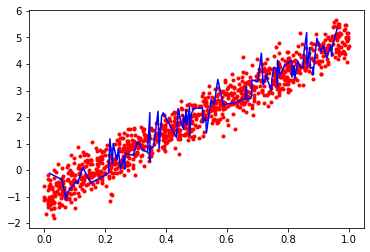

In [4]:
# g√©n√©ration de donn√©es jouets:
a = 6.
b = -1.
N = 100
sig = .4 # √©cart type

X_train, y_train, X_test, y_test = gen_data_lin(a, b, sig, N)

plt.figure()
plt.plot(X_test, y_test, 'r.')
plt.plot(X_train, y_train, 'b')

Vous devez obtenir quelque chose de la forme:
![donn√©es jouet](fig/gen_data.png)

## Validation des formules analytiques
Nous avons vu deux types de r√©solutions analytique: √† partir des estimateurs des esp√©rances et co-variances d'une part et des moindres carr√©s d'autre part. Testons les deux m√©thodes.

### Estimation de param√®tres probabilistes
 - $\hat a = \frac{cov(X,Y)}{\sigma_x^2}$
 - $\hat b = E(Y)‚àí\frac{cov(X,Y)}{\sigma_x^2} E(X)$
 
 Estimer les param√®tres, calculer l'erreur au sens des moindres carr√©s sur les donn√©es d'apprentissage et de test, puis tracer la droite de r√©gression

In [5]:
def modele_lin_analytique(X_train, y_train):
    cov = np.cov(X_train, y_train)
    ahat = cov[0,1] / cov[0,0]
    bhat = y_train.mean() - ahat * X_train.mean()
    return ahat, bhat

ahat, bhat = modele_lin_analytique(X_train, y_train)
ahat, bhat

(5.962868673244958, -0.9410445934000635)

In [6]:
def erreur_mc(y, yhat):
    return ((y-yhat)**2).mean()

yhat_train = ahat*X_train+bhat
yhat_test  = ahat*X_test+bhat

print('Erreur moyenne au sens des moindres carr√©s (train):', erreur_mc(yhat_train, y_train))
print('Erreur moyenne au sens des moindres carr√©s (test):', erreur_mc(yhat_test, y_test))

Erreur moyenne au sens des moindres carr√©s (train): 0.18130892008245733
Erreur moyenne au sens des moindres carr√©s (test): 0.17620488736837356


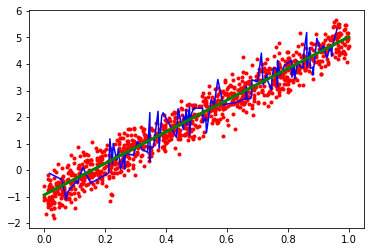

In [7]:
plt.figure()
plt.plot(X_test, y_test, 'r.')
plt.plot(X_train, y_train, 'b')
plt.plot(X_test, yhat_test, 'g', lw=3)

## Formulation au sens des moindres carr√©s

Nous partons directement sur une √©criture matricielle. Du coup, il est n√©cessaire de construire la matrice enrichie $Xe$:
    $$Xe = \left[\begin{array}{cc}
                X_0 & 1\\
                \vdots & \vdots\\
                X_N & 1
                \end{array}
                \right] $$
Le code de la fonction d'enrichissement est donn√© ci-dessous.

Il faut ensuite poser et r√©soudre un syst√®me d'√©quations lin√©aires de la forme:
$$ A w = B $$
**Rappel des formules vues en cours/TD:**
$$ A=X^T X$$
$$ B=X^T Y$$
Fonction de r√©solution: `np.linalg.solve(A,B)`
Vous devez obtenir la m√™me solution que pr√©c√©demment. 

In [8]:
def make_mat_lin_biais(X): # fonctionne pour un vecteur unidimensionel X
    N = len(X)
    return np.hstack((X.reshape(N,1),np.ones((N,1))))

In [9]:
Xe = make_mat_lin_biais(X_train)

def get_w(Xe, y):
    A = Xe.T @ Xe
    B = Xe.T @ y
    w = np.linalg.solve(A, B)
    return w

w = get_w(Xe, y_train)
print(w)

[ 5.96286867 -0.94104459]


On retrouve la m√™me chose

Soit les donn√©es polynomiales g√©n√©r√©es avec la fonction ci-dessous
 - proposer & une solution d'enrichissement (vue en cours et TD) 
 - r√©soudre analytiquement le probl√®me des moindres carr√©s
 - calculer l'erreur au sens des moindes carr√©s en apprentissage ET en test
 - tracer les donn√©es et la solution

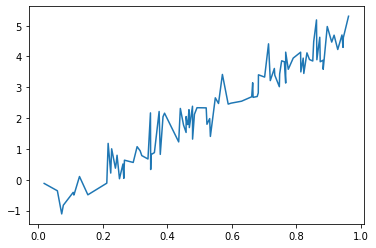

In [10]:
def gen_data_poly2(a, b, c, sig, N=500, Ntest=1000):
    '''
    Tire N points X al√©atoirement entre 0 et 1 et g√©n√®re y = ax^2 + bx + c + eps
    eps ~ N(0, sig^2)
    '''
    X_train = np.sort(np.random.rand(N))
    X_test  = np.sort(np.random.rand(Ntest))
    y_train = a*X_train**2+b*X_train+c+np.random.randn(N)*sig
    y_test  = a*X_test**2 +b*X_test +c+np.random.randn(Ntest)*sig
    return X_train, y_train, X_test, y_test

Xp_train, yp_train, Xp_test, yp_test = gen_data_poly2(10, -10, 5, 0.1, N=100, Ntest=100)
plt.figure()
plt.plot(X_train, y_train)

Erreur moyenne au sens des moindres carr√©s (train): 0.009021166070494753
Erreur moyenne au sens des moindres carr√©s (test): 0.010343989615995627


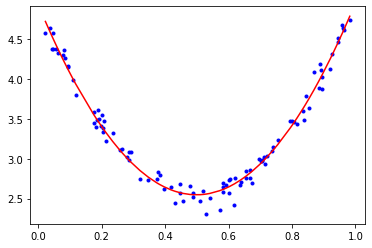

In [11]:
def make_mat_poly_biais(X): # fonctionne pour un vecteur unidimensionel X
    N = len(X)
    return np.hstack((X.reshape(N,1)**2, X.reshape(N,1), np.ones((N,1))))

Xpe   = make_mat_poly_biais(Xp_train)
Xpe_t = make_mat_poly_biais(Xp_test)
w    = get_w(Xpe, yp_train)
yphat   = (w * Xpe).sum(axis=1)
yphat_t = (w * Xpe_t).sum(axis=1)
print('Erreur moyenne au sens des moindres carr√©s (train):', erreur_mc(yphat, yp_train))
print('Erreur moyenne au sens des moindres carr√©s (test):', erreur_mc(yphat_t, yp_test))

plt.figure()
plt.plot(Xp_train, yp_train, 'b.')
plt.plot(Xp_train, yphat, 'r')

# Fonction de co√ªt & optimisation par descente de gradient

Comme vu en TD et en cours, nous allons maintenant r√©soudre le probl√®me de la r√©gression par minimisation d'une fonction de co√ªt:
$$ C = \sum_{i=1}^N (y_i - f(x_i))$$

Soit un probl√®me avec des donn√©es $(x_i,y_i)_{i=1,\ldots,N}$, une fonction de d√©cision/pr√©diction param√©tr√©e par un vecteur $w$ et une fonction de cout √† optimiser $C(w)$.
Notre but est de trouver les param√®tres $w^\star$ minimisant la fonction de co√ªt:
$$ w^\star = \arg\min_w C(w)$$

l'algorithme de la descente de gradient est le suivant (rappel):

 - $w_0 \leftarrow init$ par exemple : 0
 - boucle
     - $w_{t+1} \leftarrow w_{t} - \epsilon \nabla_w C(w_t)$

Compl√©ter le squelette d'impl√©mentation fourni ci-dessous:


In [12]:
Xe.shape, y_train.shape

((100, 2), (100,))

In [13]:
# pour travailler en matrice: (re)construction de la matrice contenant les X et un biais
Xe = make_mat_lin_biais(X_train) # dataset lin√©aire, transformation lin√©aire des donn√©es
wstar = get_w(Xe, y_train) # pour se rappeler du w optimal

def descente_grad_mc(X, y, eps=1e-4, nIterations=100):
    w = np.zeros(X.shape[1]) # init √† 0
    allw = [w]
    for i in range(nIterations):
        w = w - eps * 2 * X.T @ (X @ w - y)
        allw.append(w) # stockage de toutes les valeurs interm√©diaires pour analyse
    allw = np.array(allw)
    return w, allw # la derni√®re valeur (meilleure) + tout l'historique pour le plot
    
w, allw = descente_grad_mc(Xe, y_train, eps=1e-4, nIterations=2000)

On s'int√©resse ensuite √† comprendre la descente de gradient dans l'espace des param√®tres. Le code ci-dessous permet de tracer le cout pour un ensemble de param√®tres (toutes les valeurs de param√®tres prises par l'algorithmes au fil du temps).


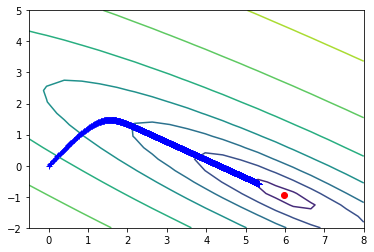

In [14]:
# tracer de l'espace des couts
def plot_parametres( allw, X, y, opti = [], ngrid = 20, extract_bornes=False):
    '''
    Fonction de trac√© d'un historique de coefficients
    ATTENTION: ca ne marche qu'en 2D (√©videmment)
    Chaque w doit contenir 2 valeurs
    
    Il faut fournir les donn√©es (X,y) pour calculer le cout associ√© 
    √† un jeu de param√®tres w
    ATTENTION X = forme matricielle des donn√©es
    '''
    w_min = [-0.5, -2] # bornes par d√©faut, uniquement pour notre cas d'usage
    w_max = [8, 5]
    if extract_bornes: # bornes g√©n√©rales
        w_min = np.min(allw,0) # trouver les bornes
        w_max = np.max(allw,0)
    # faire une grille r√©guli√®re avec tous les couples possibles entre le min et le max
    w1range = np.linspace(w_min[0], w_max[0], ngrid)
    w2range = np.linspace(w_min[1], w_max[1], ngrid)
    w1,w2 = np.meshgrid(w1range,w2range)
    #
    # calcul de tous les couts associ√©s √† tous les couples de param√®tres
    cost = np.array([[np.log(((X @ np.array([w1i,w2j])-y)**2).sum()) for w1i in w1range] for w2j in w2range])
    #
    plt.figure()
    plt.contour(w1, w2, cost)
    if len(opti) > 0:
        plt.scatter(wstar[0], wstar[1],c='r')
    plt.plot(allw[:,0],allw[:,1],'b+-' ,lw=2 )
    return
    
plot_parametres( allw, Xe, y_train, opti=wstar)
# plt.savefig('fig/grad_descente.png')

Vous devez obtenir un image de la forme :
![Descente de gradient](fig/grad_descente.png)

Tester diff√©rents jeux de param√®tres pour mettre en √©vidence les ph√©nom√®nes suivants:
 - Divergence du gradient
 - Convergence incompl√®te (trop lente ou pas assez d'it√©ration)
 - Convergence id√©ale: pas de gradient suffisamment grand et nombre d'it√©rations bien choisi

# Passage sur des donn√©es r√©elles

Apr√®s avoir √©tudi√© trois mani√®res de faire face au probl√®me de la r√©gression, nous proposons d'√©tudier un cas r√©el: la pr√©diction de la consommation des voitures en fonction de leurs caract√©ristiques.

Dans le cas pr√©sent, nous allons baser la solution sur la r√©solution analytique du probl√®me des moindres carr√©s (`np.linalg.solve(A,B)`), qui semble la mieux adapt√©e au probl√®me qui nous int√©resse.

Le jeu de donn√©es est issu des datasets UCI, un r√©pertoire parmi les plus connus en machine learning. Les donn√©es **sont d√©j√† t√©l√©charg√©es et pr√©sentes dans le tme** mais vous voulez plus d'informations:
https://archive.ics.uci.edu/ml/datasets/auto+mpg

![voiture](fig/Large9.jpg)

Apr√®s avoir import√© les donn√©es (fonction fournie), vous construirez une solution optimale et l'√©valuerez au sens des moindres carr√©s en apprentissage et en test.


In [15]:
import pandas as pd
# Chargement des donn√©es
# comme np.loadtxt mais en plus robuste
data = pd.read_csv('data/auto-mpg.data', delimiter='\s+', header=None)
# remplacement des donn√©es manquantes '?' => Nan pour travailler sur des nombres
data.iloc[:, [3]] = data.iloc[:, [3]].replace('?', None)
data.iloc[:, [3]] = data.iloc[:, [3]].astype(float)
# remplacement des valeurs manquantes par la moyenne
data.iloc[:, [3]] = data.iloc[:, [3]].fillna(data.iloc[:, [3]].mean())

print(data.head())  # visualiser ce qu'il y a dans les donn√©es

X = np.array(data.values[:, 1:-2], dtype=np.float64)
y = np.array(data.values[:, 0], dtype=np.float64)


      0  1      2      3       4     5   6  7                          8
0  18.0  8  307.0  130.0  3504.0  12.0  70  1  chevrolet chevelle malibu
1  15.0  8  350.0  165.0  3693.0  11.5  70  1          buick skylark 320
2  18.0  8  318.0  150.0  3436.0  11.0  70  1         plymouth satellite
3  16.0  8  304.0  150.0  3433.0  12.0  70  1              amc rebel sst
4  17.0  8  302.0  140.0  3449.0  10.5  70  1                ford torino


In [16]:
# separartion app/test
def separation_train_test(X, y, pc_train=0.75):
    # A compl√©ter
    # 1) g√©n√©rer tous les index entre 0 et N-1
    # 2) m√©langer la liste
    napp = int(len(y)*pc_train) # nb de points pour le train
    index = np.arange(len(X))
    np.random.shuffle(index)
    X_train, y_train = X[index[:napp]], y[index[:napp]]
    X_test, y_test   = X[index[napp:]], y[index[napp:]]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = separation_train_test(X, y, pc_train=0.75)

In [17]:
# R√©solution analytique

w = get_w(X_train, y_train)
yhat   = X_train @ w
yhat_t = X_test @ w
print('Erreur moyenne au sens des moindres carr√©s (train):', erreur_mc(yhat, y_train))
print('Erreur moyenne au sens des moindres carr√©s (test):', erreur_mc(yhat_t, y_test))


Erreur moyenne au sens des moindres carr√©s (train): 12.954079285049163
Erreur moyenne au sens des moindres carr√©s (test): 9.499247389991318


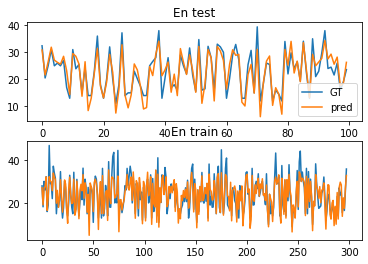

In [18]:
def plot_y(y_train, y_test, yhat, yhat_t):
    # trac√© des pr√©dictions:
    plt.figure()
    plt.subplot(211)
    plt.plot(y_test, label="GT")
    plt.plot(yhat_t, label="pred")
    plt.title('En test')
    plt.legend()
    plt.subplot(212)
    plt.plot(y_train, label="GT")
    plt.plot(yhat, label="pred")
    plt.title('En train')
    return
plot_y(y_train, y_test, yhat, yhat_t)

<BarContainer object of 6 artists>

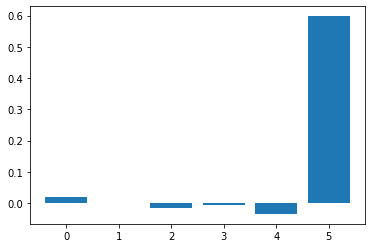

In [19]:
# interpr√©tation des poids
plt.figure()
plt.bar(np.arange(len(w)), w)

~~**La colonne 1 et la colonne 5 de X ont un impact important dans la pr√©diction de la consomation. Cela correspond √† la taille du cylindre et √† l'ann√©e du mod√®le.**~~

J'avais pas vu la suite üòÇ

## Normalisation

Sur le diagramme ci-dessus, on ne voit pas grand chose pour une raison √©vidente: on ne peut pas comparer ces poids qui comparent des variables dont les ordres de grandeur sont diff√©rents.

Nous allons donc assimiler chaque colonne $X_j$ √† une variable suivant une loi normale et nous allons revenir √† une Normale centr√©e r√©duite selon la formule de base:

$$X_j \sim \mathcal N(\mu_j, \sigma_j^2) $$
$$\Rightarrow Z_j = \frac{X_j - \mu_j}{\sigma_j} \sim \mathcal N(0, 1) $$

Tous les $Z_j$ sont comparables et nous seront en mesure de comprendre l'impact de chaque variables sur les r√©sultats.

**ATTENTION:** on ne se basera que sur les donn√©es d'apprentissage pour le calcul des $\{\mu_j, \sigma_j\}$.

Une fois la normalisation effectu√©e, analyser l'impact des diff√©rentes variables descriptives sur la valeur √† pr√©dire.

Erreur moyenne au sens des moindres carr√©s (train): 12.465189566215392
Erreur moyenne au sens des moindres carr√©s (test): 9.855542276413146


<BarContainer object of 7 artists>

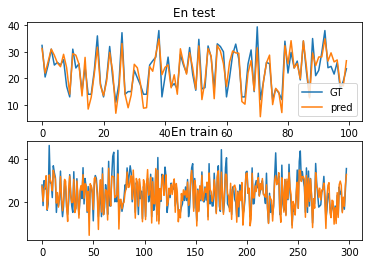

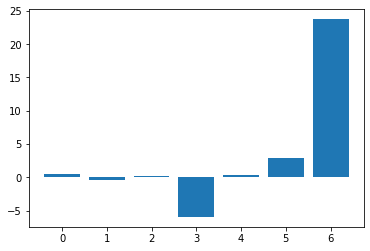

In [20]:
def normalisation(X_train, X_test):
    '''
    Fonction de normalisation des donn√©es pour rendre les colonnes comparables
    Chaque variable sera assimil√©e √† une loi normale qu'il faut centrer + r√©duire.
    ATTENTION: il faut calculer les moyennes et √©carts-types sur les donn√©es d'apprentissage seulement
    '''
    # A compl√©ter
    # 1) calcul des moyennes et √©carts types pour chaque colonne
    # 2) normalisation des colonnes
    # 3) Ajout d'un biais: fourni ci-dessous)
    mu = X_train.mean(axis=0)
    sig = X_train.std(axis=0)
    Xn_train = (X_train - mu) / sig
    Xn_test = (X_test - mu) / sig
    Xn_train = np.hstack((Xn_train, np.ones((Xn_train.shape[0], 1))))
    Xn_test   = np.hstack((Xn_test, np.ones((Xn_test.shape[0], 1))))
    return Xn_train, Xn_test

Xn_train, Xn_test = normalisation(X_train, X_test)
w = get_w(Xn_train, y_train)

yhat   = Xn_train @ w
yhat_t = Xn_test @ w
print('Erreur moyenne au sens des moindres carr√©s (train):', erreur_mc(yhat, y_train))
print('Erreur moyenne au sens des moindres carr√©s (test):', erreur_mc(yhat_t, y_test))
plot_y(y_train, y_test, yhat, yhat_t)

plt.figure()
plt.bar(np.arange(len(w)), w)

**On a un coef de plus √† cause du bias.**

# Questions d'ouverture

## S√©lection de caract√©ristiques

Quels sont les r√©sultats obtenus en √©liminant toutes les variables servent moins?

Erreur moyenne au sens des moindres carr√©s (train): 12.547232996232538
Erreur moyenne au sens des moindres carr√©s (test): 9.414897175485809


<BarContainer object of 3 artists>

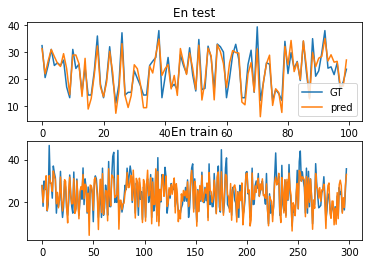

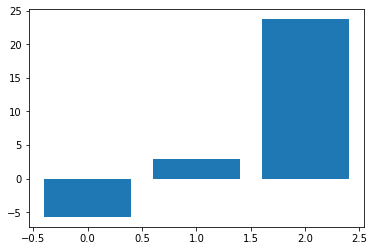

In [21]:
Xn_train, Xn_test = normalisation(X_train[:, [3,5]], X_test[:, [3,5]])
w = get_w(Xn_train, y_train)

yhat   = Xn_train @ w
yhat_t = Xn_test @ w
print('Erreur moyenne au sens des moindres carr√©s (train):', erreur_mc(yhat, y_train))
print('Erreur moyenne au sens des moindres carr√©s (test):', erreur_mc(yhat_t, y_test))
plot_y(y_train, y_test, yhat, yhat_t)

plt.figure()
plt.bar(np.arange(len(w)), w)

**Visiblement Ca se passe tr√®s bien, la MSE est plus l√©g√©rement plus faible**

**Normalement on peut faire des test stat pour savoir si les coef apporte quelque chose √† la r√©gression, c'est assez facile en R**


## Feature engineering

En √©tudiant la signification des variables du probl√®mes, on trouve:

1. mpg: continuous 
2. cylinders: multi-valued discrete 
3. displacement: continuous 
4. horsepower: continuous 
5. weight: continuous 
6. acceleration: continuous 
7. model year: multi-valued discrete 
8. origin: multi-valued discrete 

D'apr√®s la question pr√©c√©dente, le poids, l'ann√©e du mod√®le et le biais sont des facteurs important pour le calcul de la consommation... Jusqu'ici, nous n'avons pas pris en compte l'origine qui √©tait difficile √† coder.

### Encodage de l'origine

La variable origine est accessible de la mani√®re suivante:

```
  origine = data.values[:,-2]
```
Il faut le faire au d√©but du traitement pour bien conserver la s√©paration en l'apprentissage et le test.

Au moins les deux derniers facteurs discrets pourraient √™tre trait√©s diff√©remment en one-hot encoding:
$$X_j = x \in \{1, \ldots, K\} \Rightarrow [0, 0, 1, 0] \in \{0, 1\}^K$$

La valeur $x$ donne l'index de la colonne non nulle.


In [22]:
data.head(2)

0  1      2      3       4     5   6  7                          8
0  18.0  8  307.0  130.0  3504.0  12.0  70  1  chevrolet chevelle malibu
1  15.0  8  350.0  165.0  3693.0  11.5  70  1          buick skylark 320

In [31]:
origine = data.values[:, -2]
data[7].value_counts()

1    249
3     79
2     70
Name: 7, dtype: int64

0. mpg: continuous
1. cylinders: multi-valued discrete
2. displacement: continuous
3. horsepower: continuous
4. weight: continuous
5. acceleration: continuous
6. model year: multi-valued discrete
7. origin: multi-valued discrete
8. car name: string (unique for each instance)

On a 3 origines possibles

One hot encoding

In [28]:
def create_index(unique_cat):
    dict_index = dict()
    for i, cat in enumerate(unique_cat):
        dict_index[cat] = i
    return dict_index

def one_hot_encode(X):
    unique_cat = np.unique(origine)
    dict_index = create_index(unique_cat)
    oh_X = np.zeros((len(origine), len(dict_index)))
    for i, cat in enumerate(X):
        oh_X[i, dict_index[cat]] = 1
    return oh_X

In [29]:
oh_origin = one_hot_encode(origine)
oh_origin

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])


### Encodage de l'ann√©e

Pour l'ann√©e, il est possible de proc√©der de la m√™me mani√®re, mais il pr√©f√©rable de d√©couper les ann√©es en 10 cat√©gories puis d'encoder pour limiter le nombre de dimensions.

In [34]:
years = data.values[:, -3]
np.unique(years, return_counts=True), 

((array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82], dtype=object),
  array([29, 28, 28, 40, 27, 30, 34, 28, 36, 29, 29, 29, 31])),)

**Il n'y a que 13 ann√©es diff√©rente, toute plut√¥t √©quilibr√© dans le dataset. Le choix de quelles ann√©es regrouper (quelles information perdre) me semble donc assez difficile. Je ne vais pas regrouper au prix de 3 dimensions**

In [ ]:
oh_years = one_hot_encode(years)

### Regression avec encodage one hot

# Question d'ouverture sur le gradient

## La normalisation a-t-elle un impact sur le gradient?

La normalisation des donn√©es peut au moins nous aider √† r√©gler plus facilement le pas (qui sera toujours du m√™me ordre de grandeur... Mais cela a-t-il un impact sur la mani√®re dont nous nous rapprochons de la solution optimale?

## Gradient stochastique

Dans la plupart des algorithmes modernes d'optimisation li√©s aux r√©seaux de neurones, le gradient est calcul√© de mani√®re stochastique, sur un exemple √† la fois:

- $w_0 \leftarrow init$ par exemple : 0
- boucle
     - tirage d'une donn√©e $i$: $(x_i,y_i)$
     - $w_{t+1} \leftarrow w_{t} - \epsilon \nabla_w C_i(w)$


Etudier le fonctionnement de cet algorithme sur les exemples jouets pr√©c√©dents.

## Am√©lioration du gradient

Le blog de S. Ruder explique particuli√®rement bien les am√©liorations possibles sur les descentes de gradient.

https://ruder.io/optimizing-gradient-descent/

Comparer une descente de gradient stochastique avec et sans moment sur les donn√©es jouets des premi√®res questions.